# Comparing Image Upscaling Methods on CIFAR-10 (TensorFlow)

This notebook demonstrates different interpolation strategies for upscaling low-resolution images from the CIFAR-10 dataset using TensorFlow/Keras 2.15.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from PIL import Image
from tabulate import tabulate

print(f"TensorFlow version: {tf.__version__}")

2024-11-21 10:37:45.167311: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 10:37:45.774434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 10:37:45.774569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 10:37:45.903457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 10:37:46.146025: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 10:37:46.150118: I tensorflow/core/platform/cpu_feature_guard.cc:1

TensorFlow version: 2.15.0


In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), _ = keras.datasets.cifar10.load_data()

# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# Get one image from each class
class_images = {}
found_classes = set()

for img, label in zip(x_train, y_train):
    class_name = classes[label[0]]
    if class_name not in found_classes:
        class_images[class_name] = img
        found_classes.add(class_name)
    if len(found_classes) == len(classes):
        break

In [3]:
def upscale_image(image, target_size, method):
    """Upscale image using specified interpolation method"""
    # Add batch dimension and convert to float32
    img = tf.convert_to_tensor(image)
    img = tf.cast(img, tf.float32)
    img = tf.expand_dims(img, 0)
    
    # Resize image
    resized = tf.image.resize(img, 
                             [target_size, target_size],
                             method=method)
    
    # Convert back to uint8
    resized = tf.clip_by_value(resized, 0, 255)
    resized = tf.cast(resized, tf.uint8)
    return resized[0].numpy()

# Interpolation methods to compare
methods = {
    'Nearest': tf.image.ResizeMethod.NEAREST_NEIGHBOR,
    'Bilinear': tf.image.ResizeMethod.BILINEAR,
    'Bicubic': tf.image.ResizeMethod.BICUBIC,
    'Lanczos3': tf.image.ResizeMethod.LANCZOS3,
    'Lanczos5': tf.image.ResizeMethod.LANCZOS5,
    'Gaussian': tf.image.ResizeMethod.GAUSSIAN
}

target_size = 384  # Target size for upscaling

In [4]:
def create_comparison_table(class_name, image):
    """Create a figure comparing different interpolation methods"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Upscaling Comparison for {class_name} (32x32 → {target_size}x{target_size})', fontsize=16)
    
    # Add timing information
    times = {}
    
    for (method_name, method), ax in zip(methods.items(), axes.flat):
        # Time the upscaling
        start_time = tf.timestamp()
        upscaled = upscale_image(image, target_size, method)
        end_time = tf.timestamp()
        times[method_name] = (end_time - start_time).numpy()
        
        ax.imshow(upscaled)
        ax.set_title(f'{method_name}\n({times[method_name]:.3f}s)')
        ax.axis('off')
    
    plt.tight_layout()
    return fig, times

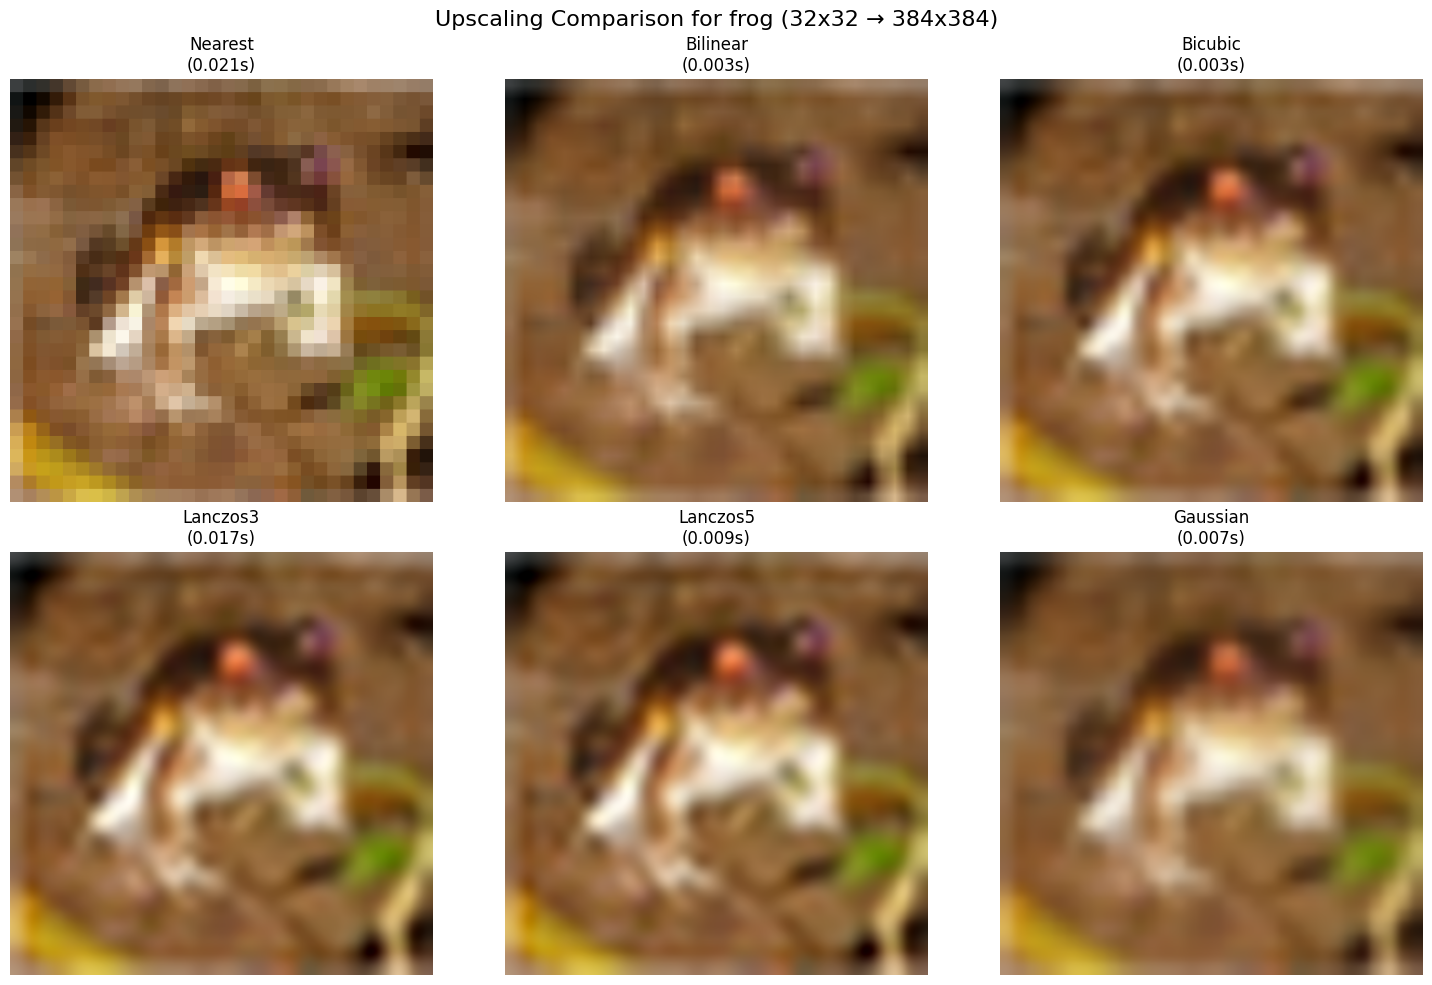

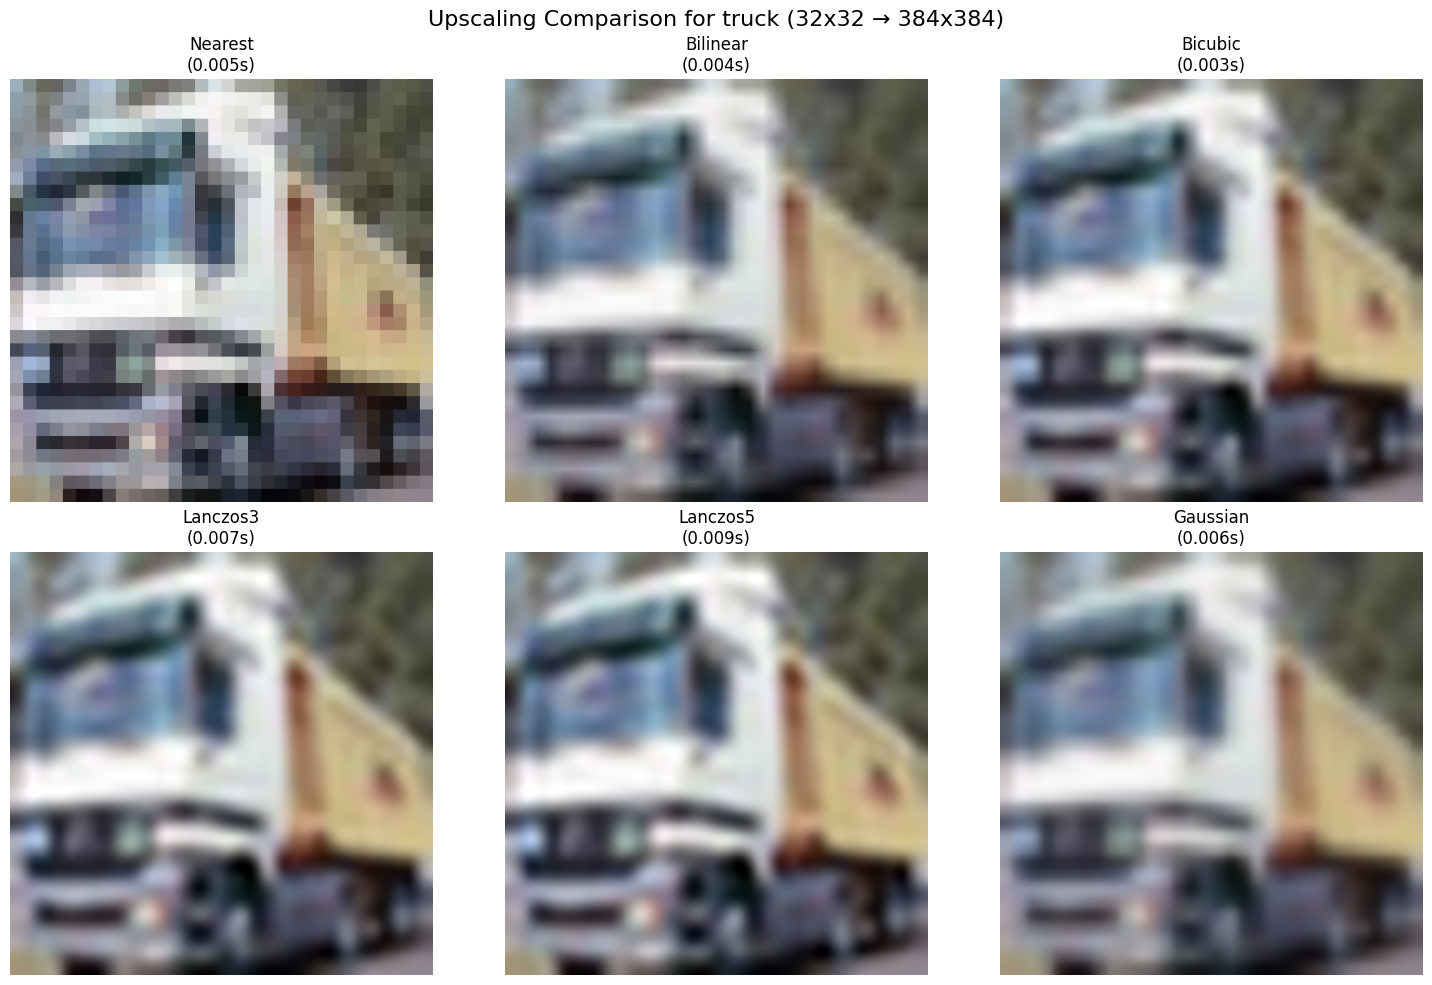

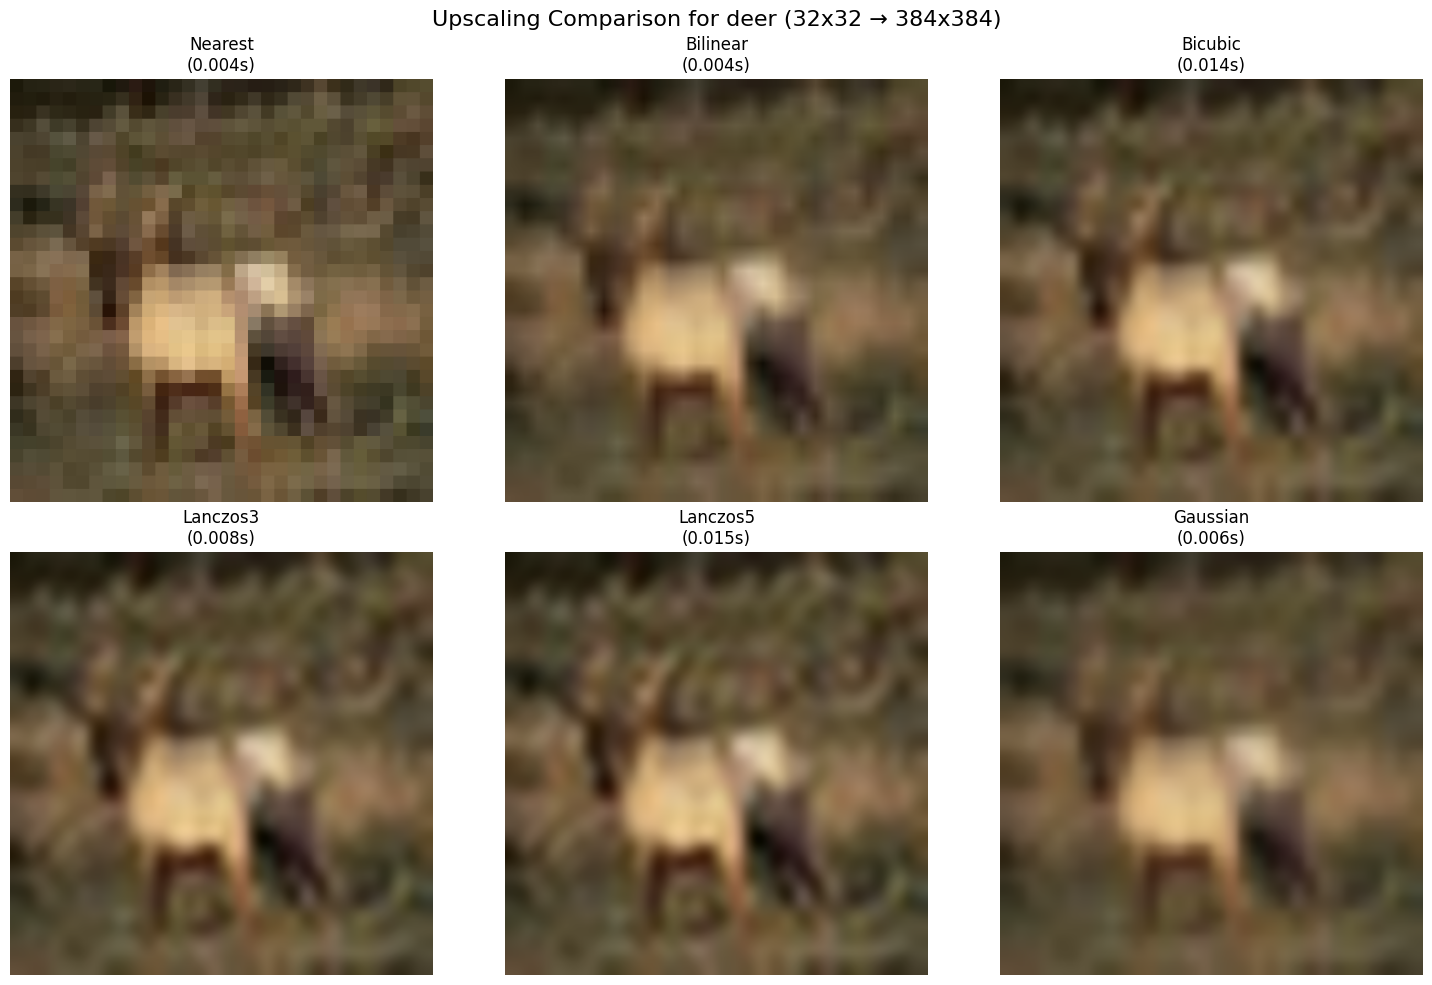

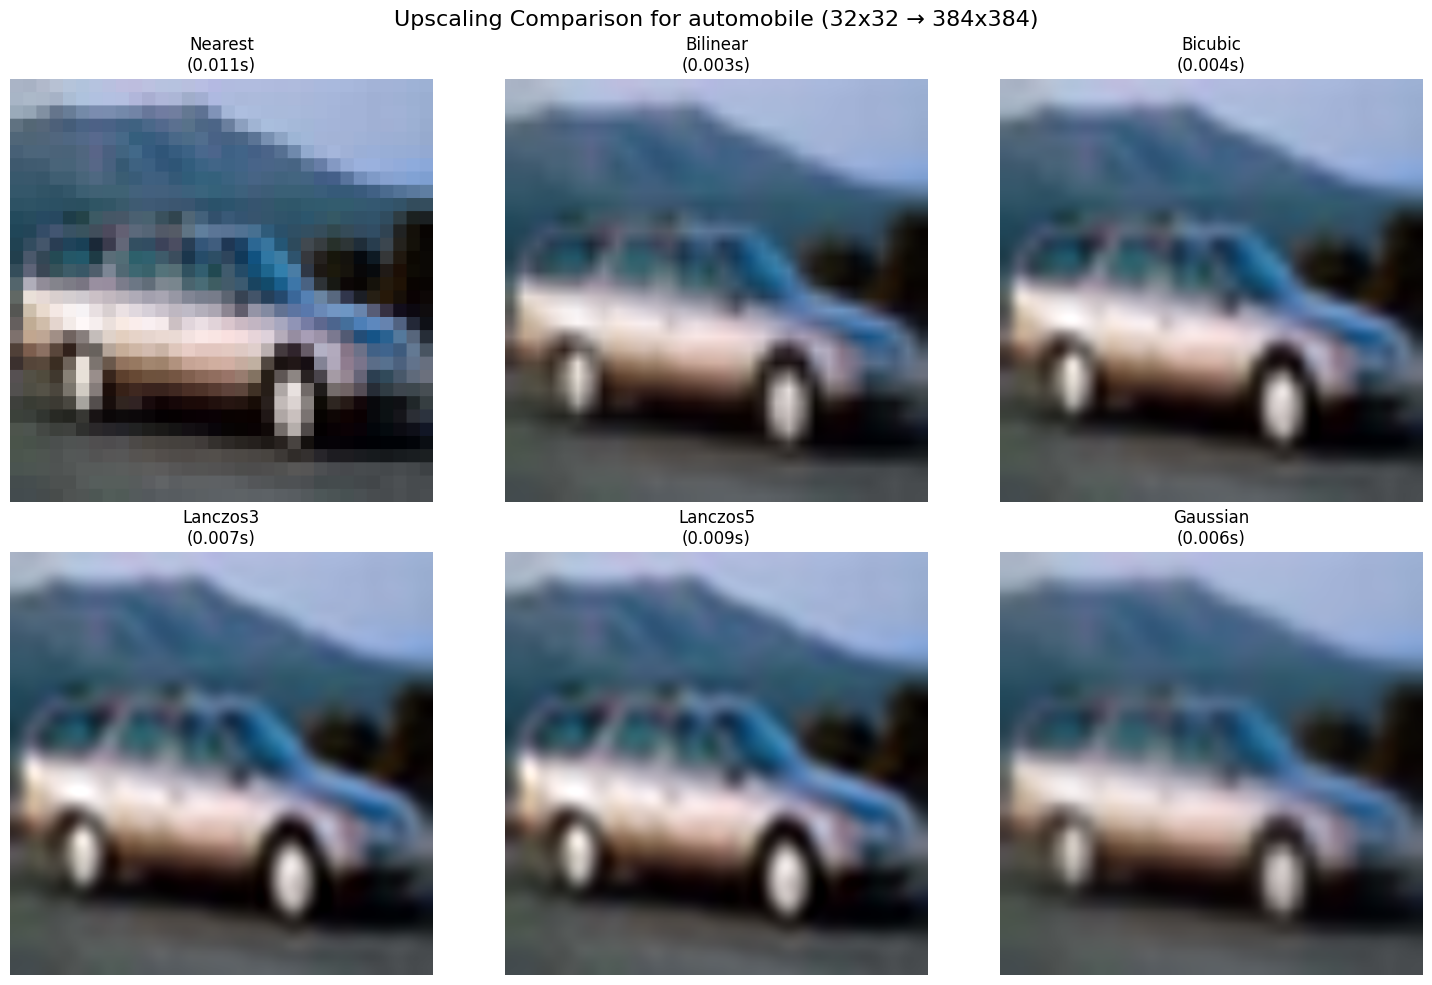

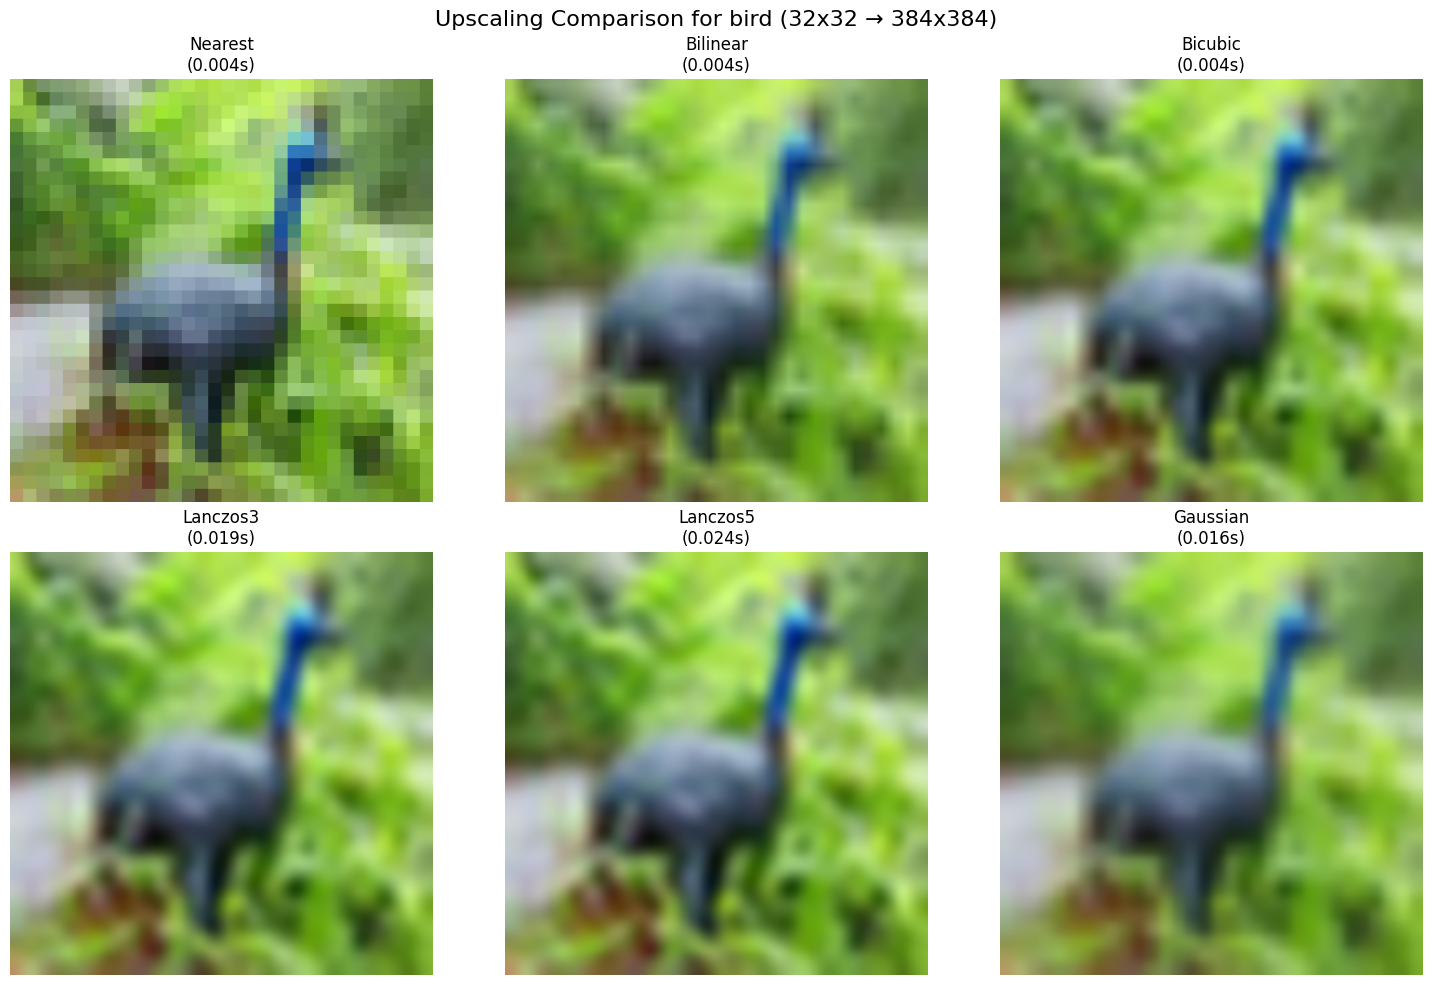

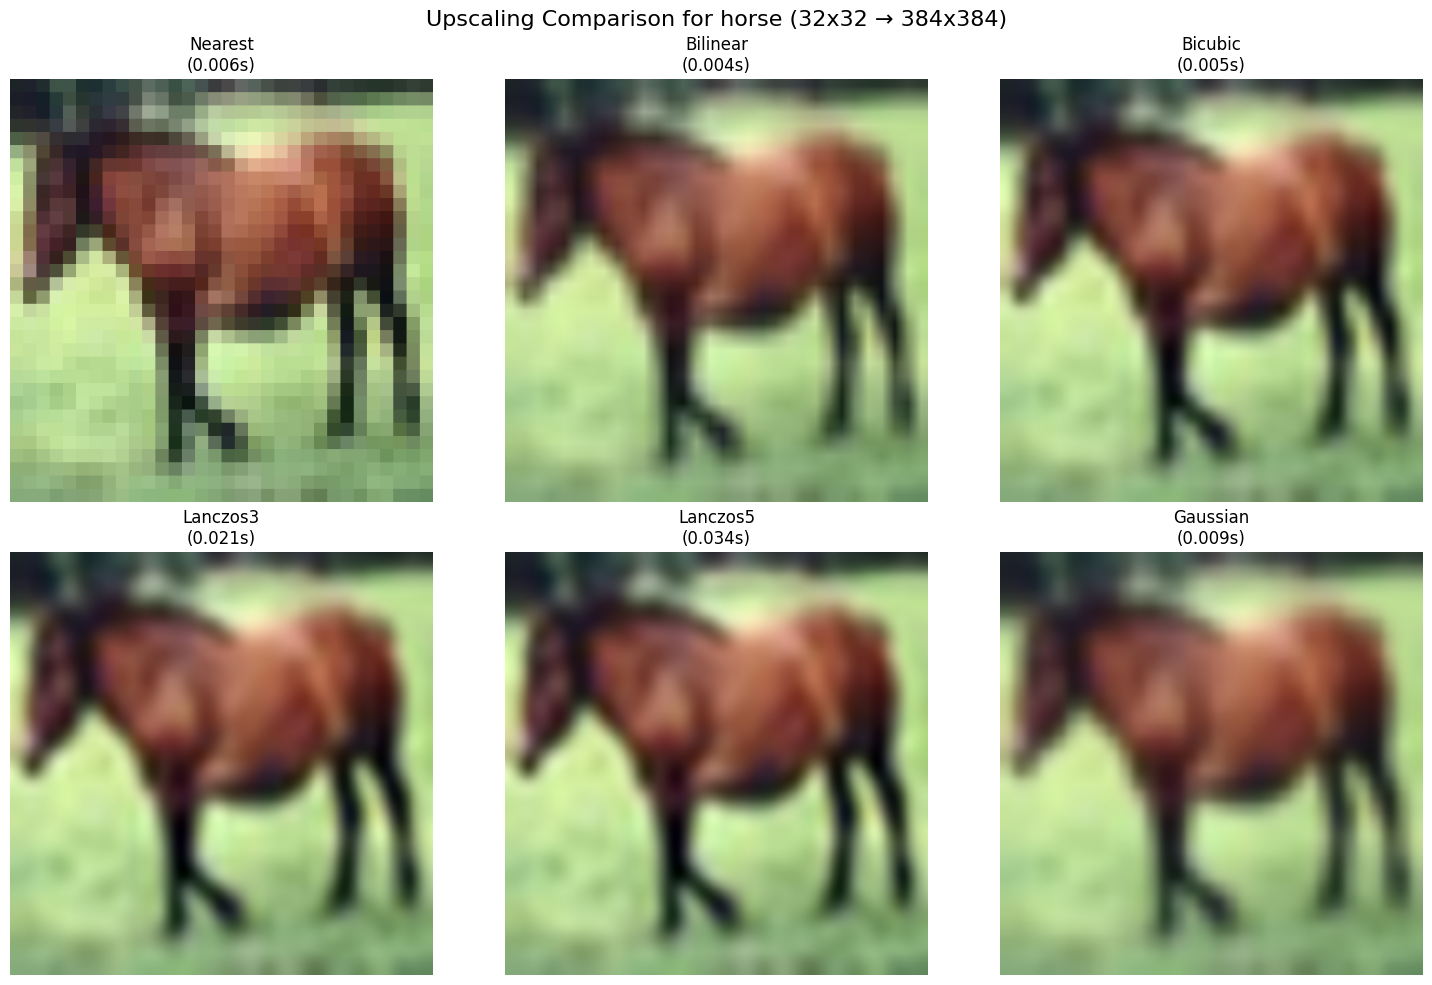

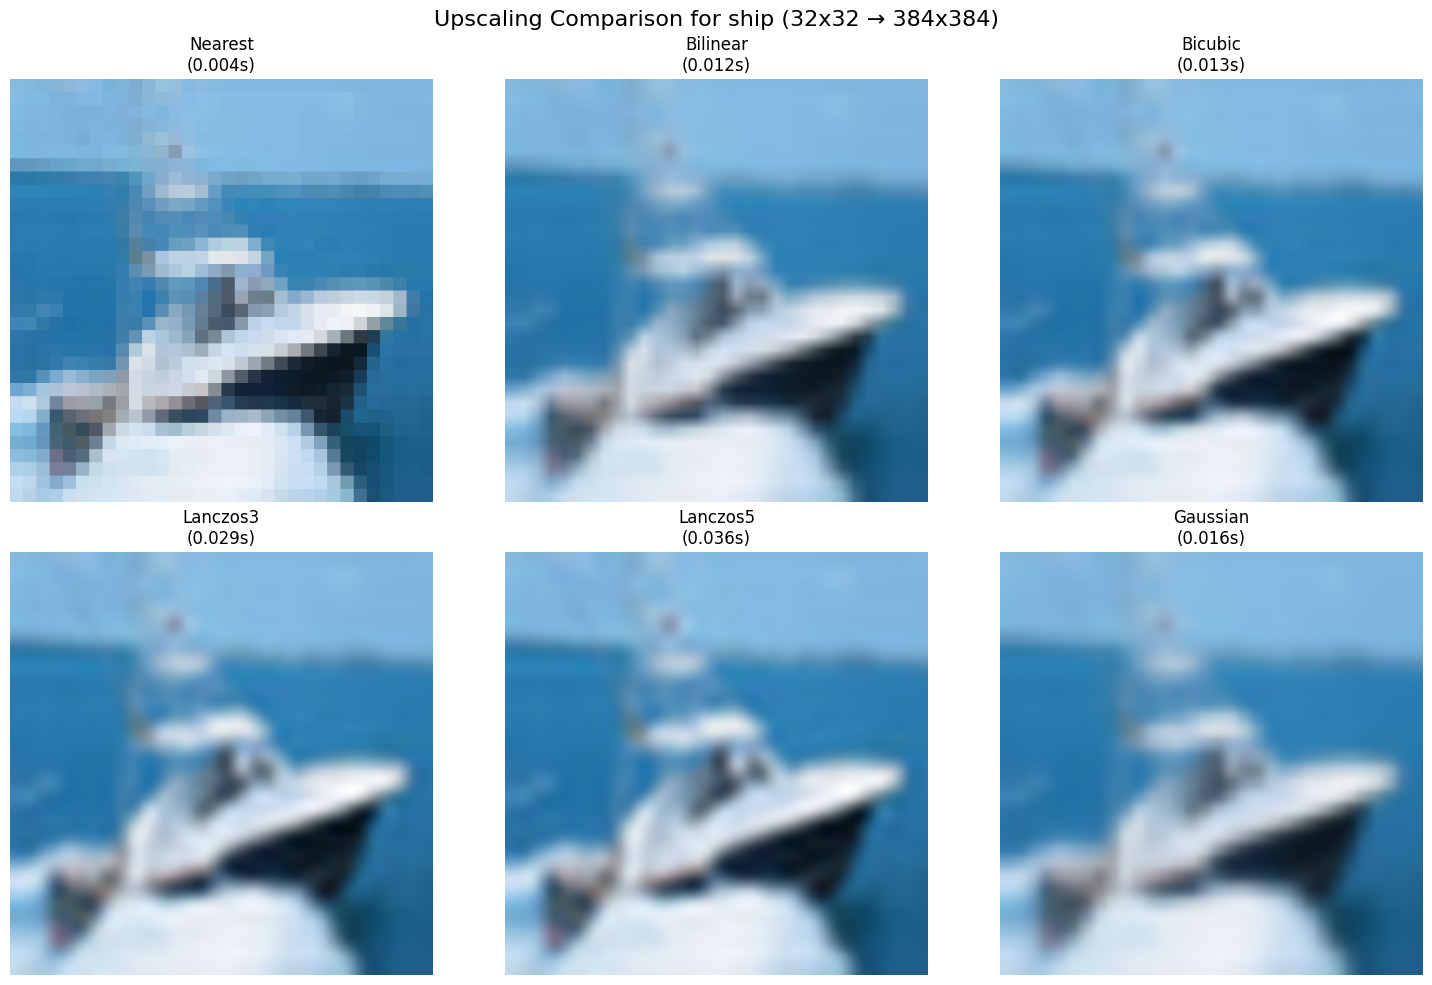

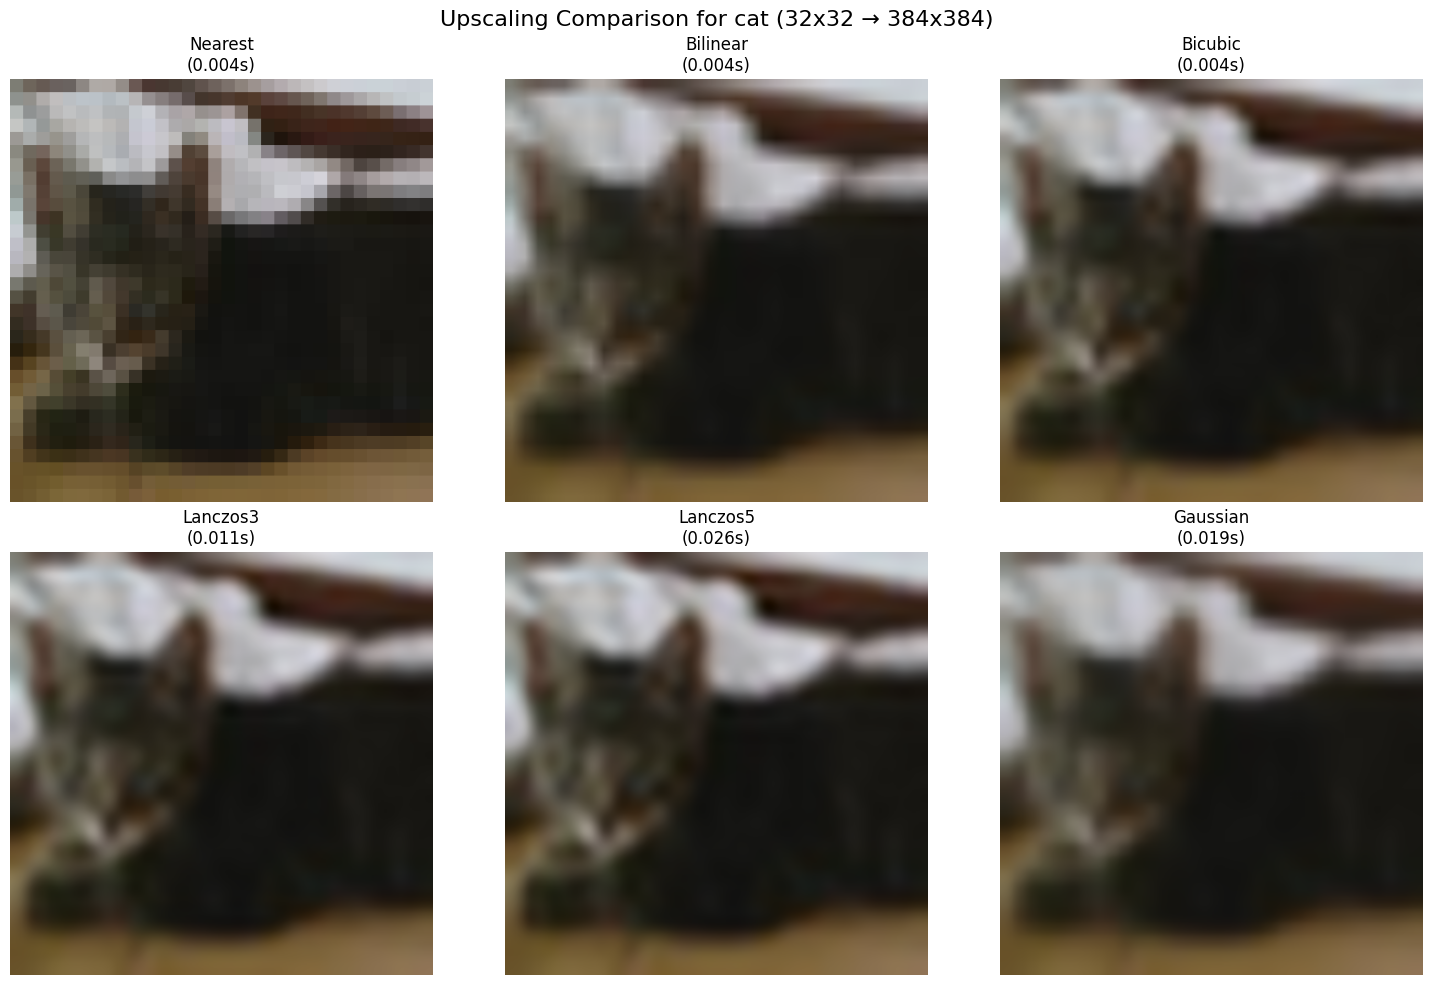

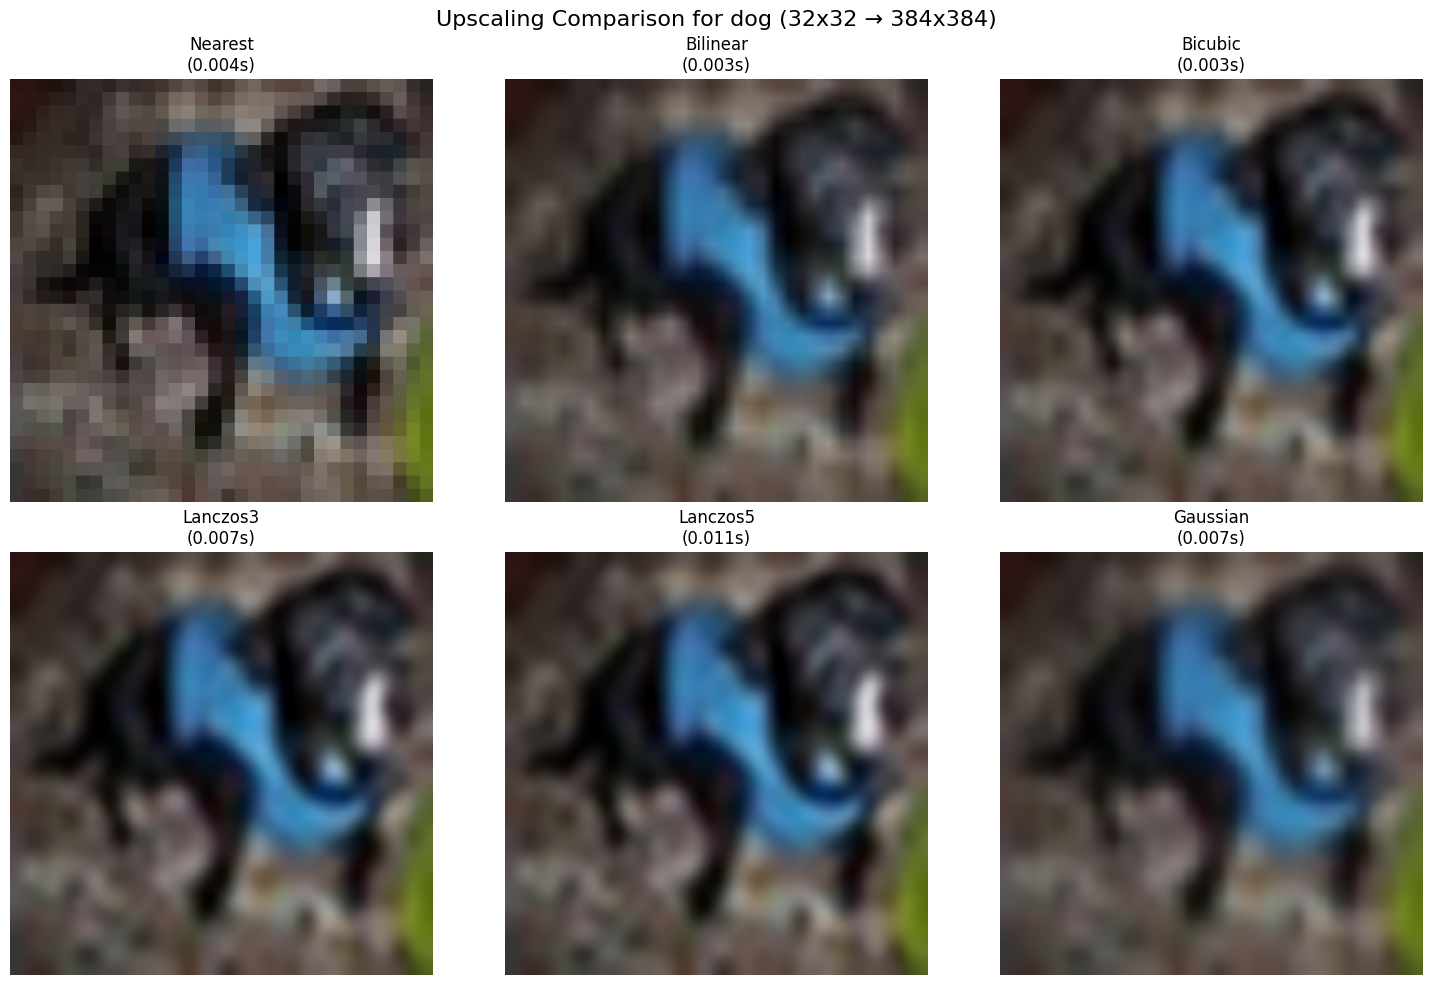

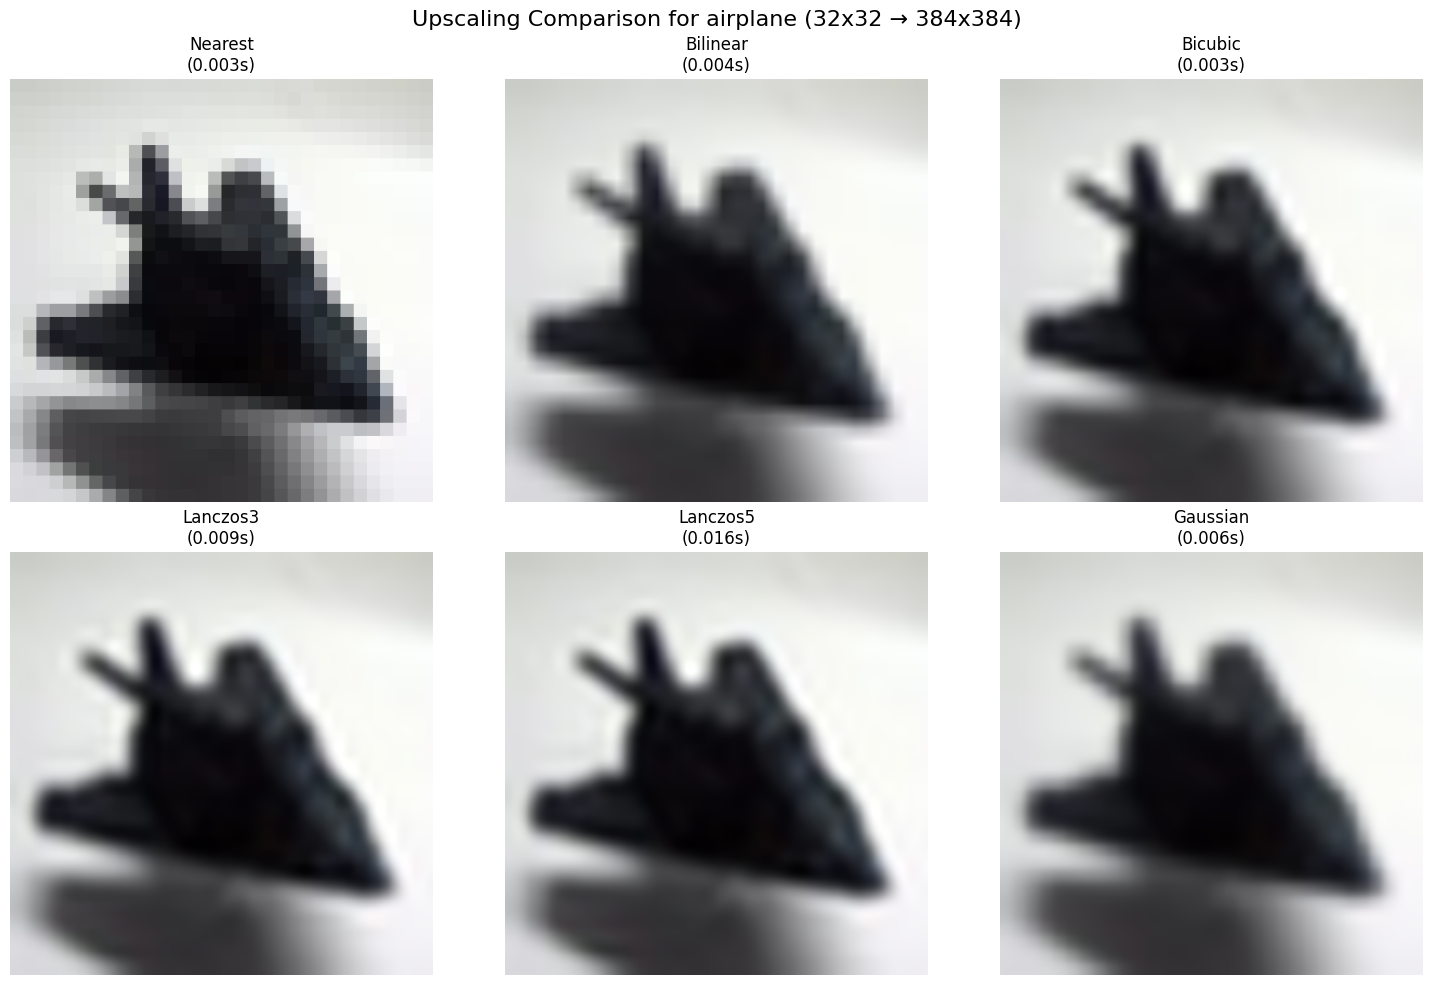

In [5]:
# Create comparison tables for each class
all_times = {}

for class_name, image in class_images.items():
    fig, times = create_comparison_table(class_name, image)
    all_times[class_name] = times
    plt.show()

In [6]:
# Calculate and display average timing results
avg_times = {method: np.mean([times[method] for times in all_times.values()])
            for method in methods.keys()}

print("Average processing times (seconds):")
for method, time in avg_times.items():
    print(f"{method:12s}: {time:.3f}s")

Average processing times (seconds):
Nearest     : 0.006s
Bilinear    : 0.005s
Bicubic     : 0.006s
Lanczos3    : 0.013s
Lanczos5    : 0.019s
Gaussian    : 0.010s


## Observations

1. **Nearest Neighbor**:
   - Fastest method
   - Most blocky appearance
   - No antialiasing

2. **Bilinear**:
   - Good balance of speed and quality
   - Slight blurring
   - Works well for natural images

3. **Bicubic**:
   - Better detail preservation than bilinear
   - Can produce slight ringing artifacts
   - Good for photographic content

4. **Lanczos3**:
   - High quality upscaling
   - Sharp edges with minimal artifacts
   - Slower than simpler methods

5. **Lanczos5**:
   - Highest quality for detailed images
   - Most computationally intensive
   - Best for final renders

6. **Gaussian**:
   - Smooth results with some blur
   - Good noise reduction
   - Balance between speed and quality

### Key Differences from PIL Implementation:
- TensorFlow offers Lanczos3 and Lanczos5 separately
- Includes Gaussian interpolation instead of Box/Hamming
- Generally faster due to GPU acceleration when available

### Recommendations:
- Real-time applications: Nearest Neighbor or Bilinear
- Quality-critical applications: Lanczos5 or Bicubic
- Balanced approach: Lanczos3 or Gaussian